In [80]:
from typing import Any
import numpy as np 
from scipy.spatial.transform import Rotation as R

class RandomRot:

    def __init__(self, theta=np.pi*10/180):
        self.theta = theta

    def _rot3d(self, theta):
        cos, sin = np.cos(theta), np.sin(theta)
        rx = np.array([[1, 0, 0], [0, cos[0], sin[0]], [0, -sin[0], cos[0]]])
        ry = np.array([[cos[1], 0, -sin[1]], [0, 1, 0], [sin[1], 0, cos[1]]])
        rz = np.array([[cos[2], sin[2], 0], [-sin[2], cos[2], 0], [0, 0, 1]])

        rot = np.matmul(rz, np.matmul(ry, rx))
        return rot

    def _rot2d(self, theta):
        cos, sin = np.cos(theta), np.sin(theta)
        return np.array([[cos, -sin], [sin, cos]])

    def __call__(self, kp):
        skeleton = kp[:,:,:2]
        T, V, C = skeleton.shape

        if np.all(np.isclose(skeleton, 0)):
            return results

        assert C in [2, 3]
        if C == 3:
            theta = np.random.uniform(-self.theta, self.theta, size=3)
            rot_mat = self._rot3d(theta)
        elif C == 2:
            theta = np.random.uniform(-self.theta, self.theta)
            rot_mat = self._rot2d(theta)
        results = kp.copy()
        
        results[:,:,:2] = np.einsum('ab,tvb->tva', rot_mat, skeleton)

        return results
    
    
class RandomScale:

    def __init__(self, scale=0.1):
        assert isinstance(scale, tuple) or isinstance(scale, float)
        self.scale = scale

    def __call__(self, kp):
        skeleton = kp[:,:,:2]
        scale = self.scale
        if isinstance(scale, float):
            scale = (scale, ) * skeleton.shape[-1]
        assert len(scale) == skeleton.shape[-1]
        # scale = 1 + np.random.uniform(-1, 1, size=len(scale)) * np.array(scale)
        results = kp.copy()
        results[:,:,:2] = skeleton * scale
        return results


class RandomFlip:
    def __init__(self, flip_prob=0.5):
        self.flip_prob1 = flip_prob
        
    def __call__(self, kp, image_size=(480, 640)):
        skeleton = kp[:,:,:2]
        results = kp.copy()
        if np.random.uniform(low=-0, high=1) > 0.5: 
            # x_center = np.expand_dims(0.5*(skeleton[:,5,0] + skeleton[:,6,0]),axis=1)
            # center = np.concatenate((x_center, np.zeros_like(x_center)), axis=1)
            results[:,:,:2] = skeleton*[-1, 1] + [0.5*image_size[0], 0]
        return results

class RandomAngle: 
    def __init__(self):
        self.mu, self.sigma = 0, 10.0

    def __call__(self, kp):
        skeleton = kp[:,:,:2]
        results = kp.copy()

In [172]:
import numpy as np 

class RandomRot:

    def __init__(self, theta=np.pi*15/180):
        self.theta = theta

    def _rot3d(self, theta):
        cos, sin = np.cos(theta), np.sin(theta)
        rx = np.array([[1, 0, 0], [0, cos[0], sin[0]], [0, -sin[0], cos[0]]])
        ry = np.array([[cos[1], 0, -sin[1]], [0, 1, 0], [sin[1], 0, cos[1]]])
        rz = np.array([[cos[2], sin[2], 0], [-sin[2], cos[2], 0], [0, 0, 1]])

        rot = np.matmul(rz, np.matmul(ry, rx))
        return rot

    def _rot2d(self, theta):
        cos, sin = np.cos(theta), np.sin(theta)
        return np.array([[cos, -sin], [sin, cos]])

    def __call__(self, kp):
        skeleton = kp[:,:,:2].copy()
        T, V, C = skeleton.shape

        if np.all(np.isclose(skeleton, 0)):
            return results

        assert C in [2, 3]
        if C == 3:
            theta = np.random.uniform(-self.theta, self.theta, size=3)
            rot_mat = self._rot3d(theta)
        elif C == 2:
            theta = np.random.uniform(-self.theta, self.theta)
            rot_mat = self._rot2d(theta)
        results = kp.copy()
        
        results[:,:,:2] = np.einsum('ab,tvb->tva', rot_mat, skeleton)

        return results
    
    
class RandomScale:

    def __init__(self, scale=0.1):
        assert isinstance(scale, tuple) or isinstance(scale, float)
        self.scale = scale

    def __call__(self, kp):
        skeleton = kp[:,:,:2]
        scale = self.scale
        if isinstance(scale, float):
            scale = (scale, ) * skeleton.shape[-1]
        assert len(scale) == skeleton.shape[-1]
        scale = 1 + np.random.uniform(-1, 1, size=len(scale)) * np.array(scale)
        results = kp.copy()
        results[:,:,:2] = skeleton * scale
        return results


class RandomFlip:
    def __init__(self, flip_prob=0.5):
        self.flip_prob1 = flip_prob
        
    def __call__(self, kp, image_size):
        skeleton = kp[:,:,:2]
        results = kp.copy()
        if np.random.uniform(low=-0, high=1) > 0.5: 
            # x_center = np.expand_dims(0.5*(skeleton[:,5,0] + skeleton[:,6,0]),axis=1)
            # center = np.concatenate((x_center, np.zeros_like(x_center)), axis=1)
            results[:,:,:2] = skeleton*[-1, 1] + [image_size[1], 0]
        return results


In [82]:
import pandas as pd 
skeleton  = pd.read_pickle('chicken_swing (4).pkl')[0]

In [173]:
import cv2 
def vis_pose(image, pose_result, threshold=0.3, node_label=None):
    
    keypoints = pose_result[:,:2]
    keypoints_score = pose_result[:,2]

    skeleton_edge = [[15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
                        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9],
                        [8, 10], [1, 2], [0, 1], [0, 2], [1,   3], [2, 4],
                        [3, 5], [4, 6]]
    for edge in skeleton_edge:
        start = keypoints[edge[0]]
        end = keypoints[edge[1]]
        if keypoints_score[edge[0]] < threshold or keypoints_score[edge[1]] < threshold:
            continue
        image = cv2.line(image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (255, 255, 0), 2)

    for i in range(17):
        if keypoints_score[i] < threshold:
            continue
        (x, y) = keypoints[i]
        if node_label is None:
            color = (255, 255, 255)
        else:
            if node_label[i] == 0:
                color = (255, 255, 255)
            elif node_label[i] == 1:
                color = (0, 0, 255)
            elif node_label[i] == 2:
                color = (255, 0, 0)

        image = cv2.circle(image, (int(x), int(y)), 8, color, -1)

    # image_vis = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 1)
    return image


In [174]:
random_rot = RandomRot()
random_scale = RandomScale(scale=0.3)
random_flip = RandomFlip()

In [175]:

def spatial_agumentation(kp, image_size, theta=np.pi*10/180, scale=0.2): 
    random_rot = RandomRot(theta)
    random_scale = RandomScale(scale)
    random_flip = RandomFlip(0.5)
    kp = random_flip(kp, image_size)
    if np.random.uniform(high=1, low=0) > 0.5: 
        kp = random_rot(kp)
    else: 
        kp = random_scale(kp)
    return kp

In [176]:
def resize_img(im, new_shape=(640, 480), color=(0, 0, 0), auto=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im

In [177]:
kp.shape

(17, 3)

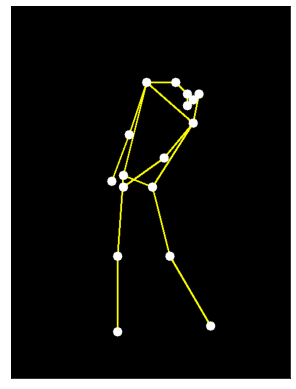

In [223]:
import pandas as pd 
skeleton  = pd.read_pickle('sample3.pkl')[2]
kp = skeleton['keypoints']
image_size = skeleton['image size']
label = skeleton['label']
kp_aug = np.expand_dims(kp, axis=0)
kp_aug = random_flip(kp_aug, image_size)
kp = kp_aug[0]
# kp = random_rot(kp)
# kp = random_flip(kp, image_size)
# kp = spatial_agumentation(kp, image_size)
skeleton_frame = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 0
frame_vis = vis_pose(skeleton_frame, kp)
import matplotlib.pyplot as plt 
figure, axis = plt.subplots(1, 1)
figure.set_dpi=400
figure.set_size_inches(5, 10)
axis.imshow(frame_vis)
axis.set_xticks([])
axis.set_yticks([])
# plt.axis('off') 
figure.savefig('scale.png')


In [140]:
skeleton

{'video name': '1.mp4',
 'pose_results': array([[[538.25      , 153.83398   ,   0.8753094 ],
         [547.875     , 142.81836   ,   0.91096485],
         [527.25      , 144.19531   ,   0.91879445],
         ...,
         [469.5       , 462.27148   ,   0.8245953 ],
         [626.25      , 587.5742    ,   0.9257623 ],
         [428.25      , 587.5742    ,   0.9743818 ]],
 
        [[539.6406    , 152.66406   ,   0.8858024 ],
         [549.3021    , 141.63281   ,   0.9216312 ],
         [528.599     , 144.39062   ,   0.9317892 ],
         ...,
         [470.6302    , 462.91797   ,   0.82554245],
         [626.59375   , 588.39844   ,   0.93084675],
         [429.22394   , 587.01953   ,   0.9712059 ]],
 
        [[540.5105    , 152.66406   ,   0.89421684],
         [550.1537    , 141.63281   ,   0.9308998 ],
         [529.4896    , 143.01172   ,   0.9392243 ],
         ...,
         [470.25262   , 462.91797   ,   0.8278682 ],
         [625.9219    , 588.39844   ,   0.93301195],
         [4

In [16]:
label

[214, 296, 327, 380]

In [701]:
def multi_input(data):
    conn = ((0, 0), (1, 0), (2, 0), (3, 1), (4, 2), (5, 3), (6, 4), (7, 5), (8, 6), (9, 7), (10, 8),
                          (11, 0), (12, 0), (13, 11), (14, 12), (15, 13), (16, 14))
    data = np.transpose(data, (2, 0, 1)) # T V C -> C T V
    C, T, V = data.shape 
    joint = np.zeros((C*2, T, V))
    velocity = np.zeros((C*2, T, V))
    bone = np.zeros((2*C,T, V))
    joint[:C, :,:] = data
    for i in range(V):
        joint[C:,:,i] = data[:,:,i] - data[:,:,0]

   

    for i in range(T-2): 
        velocity[:C,i,:] = data[:,i+1,:] - data[:,i,:]
        velocity[C:,i,:] = data[:,i+2,:] - data[:,i,:]


    for v1, v2 in conn: 
      
        bone[:C,:,v1] = data[:,:,v1] - data[:,:,v2]
    bone_length = 0

    for i in range(C): 
        bone_length += bone[i,:,:] ** 2
    bone_length = np.sqrt(bone_length) + 0.0001

    for i in range(C): 
        bone[C+i,:,:] = np.arccos(bone[i,:,:] / bone_length)
    
    return joint, velocity, bone

    

In [702]:
joint, velocity, bone = multi_input(kp[:,:,:2])

In [711]:
rel = np.transpose(velocity, (1, 2, 0))[:,:,2:]

In [712]:
def vis_pose(image, pose_result, threshold=0.3, node_label=None):
    
    keypoints = pose_result[:,:2]
    # keypoints_score = pose_result[:,2]

    skeleton_edge = [[15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
                        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9],
                        [8, 10], [1, 2], [0, 1], [0, 2], [1,   3], [2, 4],
                        [3, 5], [4, 6]]
    for edge in skeleton_edge:
        start = keypoints[edge[0]]
        end = keypoints[edge[1]]
        # if keypoints_score[edge[0]] < threshold or keypoints_score[edge[1]] < threshold:
            # continue
        image = cv2.line(image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (255, 255, 0), 2)

    for i in range(17):
        # if keypoints_score[i] < threshold:
        #     continue
        (x, y) = keypoints[i]
        if node_label is None:
            color = (255, 255, 255)
        else:
            if node_label[i] == 0:
                color = (255, 255, 255)
            elif node_label[i] == 1:
                color = (0, 0, 255)
            elif node_label[i] == 2:
                color = (255, 0, 0)

        image = cv2.circle(image, (int(x), int(y)), 5, color, -1)

    # image_vis = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 1)
    return image


[]

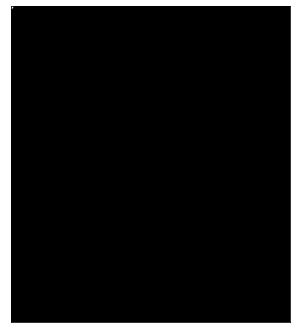

In [713]:
skeleton_frame = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 0
frame_vis = vis_pose(skeleton_frame, rel[100])
import matplotlib.pyplot as plt 
figure, axis = plt.subplots(1, 1)
figure.set_dpi=400
figure.set_size_inches(5, 10)
axis.imshow(frame_vis)
axis.set_xticks([])
axis.set_yticks([])